In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys,os
from os.path import join
sys.path.insert(0, '/home/monte.flora/python_packages/scikit-explain/')
import skexplain 

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from disagreement_stats import feature_agreement, rank_agreement, rank_correlation, weak_rank_agreement, rbo

### Create a Toy Dataset 

In [3]:
def create_corr_pair(num_samples, correlation_strength):
    covs = [[1.0, correlation_strength], [correlation_strength, 1.0]]
    means = [0,0]
    
    return np.random.multivariate_normal(means, covs, num_samples).T
def create_correlated_dataset(num_samples, num_features, num_correlated, correlation_strength, coefs=None):
    
    # Generate uncorrelated random features
    rs = np.random.RandomState(123)
    dataset = rs.randn(num_samples, num_features)
    random_features = rs.choice(num_features, size=num_correlated, replace=False)
    
    d = num_features//2
    
    assert num_correlated <= d, 'Too many correlated features!'
    
    for i in range(num_correlated):
        m1,m2 = create_corr_pair(num_samples, correlation_strength)
        dataset[:,i] = m1
        dataset[:,i+d] = m2
    
    X = pd.DataFrame(dataset, columns = [f'X_{i+1}' for i in range(dataset.shape[1])])
    y =None
    if coefs is not None:
        y = X.dot(coefs)
    
    return X,y

<AxesSubplot:>

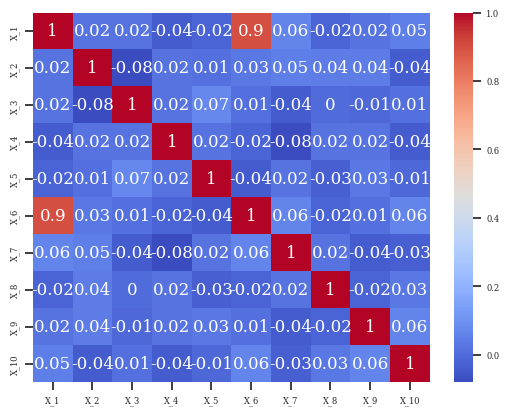

In [10]:
X,y = create_correlated_dataset(1000, 10, 1, 0.9)
sns.heatmap(np.round(X.corr(),2), annot=True, cmap="coolwarm")

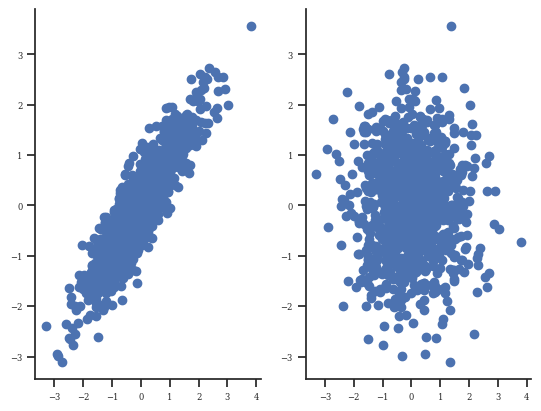

In [11]:
f, axes = plt.subplots(dpi=100, ncols=2)

axes[0].scatter(X.values[:,0], X.values[:,5])
axes[1].scatter(X.values[:,0], np.random.permutation(X.values[:,5]))

### Experiment

In [7]:
num_samples = 10000
num_features = 10 
num_correlated = [1]
correlation_strength = [ 0.9]
n_permute = 100 

all_coefs = np.linspace(0.3, 2.0, 20)
rs = np.random.RandomState(123)
coefs = rs.choice(all_coefs, size=num_features, replace=False)
coefs.sort()

In [8]:
sp_rank_stats = np.zeros((len(num_correlated), len(correlation_strength)))
mp_rank_stats = np.zeros((len(num_correlated), len(correlation_strength)))

true_rank_stats = np.zeros((len(num_correlated), len(correlation_strength)))
true_rank = ['X_10', 'X_9', 'X_8', 'X_7', 'X_6', 'X_5', 'X_4', 'X_3', 'X_2', 'X_1']

for i, nc in enumerate(num_correlated):
    for j, cs in enumerate(correlation_strength):

        X,y = create_correlated_dataset(num_samples, num_features, nc, cs, coefs)

        lr = LinearRegression().fit(X,y)
        explainer = skexplain.ExplainToolkit(('LR',  lr), X, y)

        backward_results= explainer.permutation_importance(n_vars=num_features-1, 
                                           evaluation_fn='mse', 
                                           direction='backward', 
                                           n_permute=n_permute, 
                                           return_iterations=False,
                                           n_jobs=num_features,
                                          )

        forward_results = explainer.permutation_importance(n_vars=num_features-1, 
                                           evaluation_fn='mse', 
                                           direction='forward', 
                                           n_permute=n_permute, 
                                           return_iterations=False,
                                           n_jobs=num_features,
                                          )

        r1_sp = backward_results['backward_singlepass_rankings__LR'].values
        r2_sp = forward_results['forward_singlepass_rankings__LR'].values
        
        r1_mp = backward_results['backward_multipass_rankings__LR'].values
        r2_mp = forward_results['forward_multipass_rankings__LR'].values

        print(f'True : {true_rank}')
        print(f'BSP : {r1_sp}')
        print(f'BMP : {r1_mp}')
        print(f'FSP : {r2_sp}')
        print(f'FMP : {r2_mp}')
        
        sp_rank_stats[i,j] = rank_agreement(r1_sp, r2_sp)
        mp_rank_stats[i,j] = rank_agreement(r1_mp, r2_mp)
        true_rank_stats[i,j] = rank_agreement(r1_mp, r2_mp)
        

Perm. Imp.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.83it/s]


True : ['X_10', 'X_9', 'X_8', 'X_7', 'X_6', 'X_5', 'X_4', 'X_3', 'X_2', 'X_1']
BSP : ['X_10' 'X_9' 'X_8' 'X_7' 'X_6' 'X_5' 'X_4' 'X_3' 'X_2' 'X_1']
BMP : ['X_10' 'X_9' 'X_8' 'X_7' 'X_6' 'X_5' 'X_4' 'X_3' 'X_1']
FSP : ['X_10' 'X_9' 'X_8' 'X_6' 'X_7' 'X_5' 'X_1' 'X_4' 'X_3' 'X_2']
FMP : ['X_10' 'X_9' 'X_6' 'X_8' 'X_7' 'X_5' 'X_4' 'X_3' 'X_2']


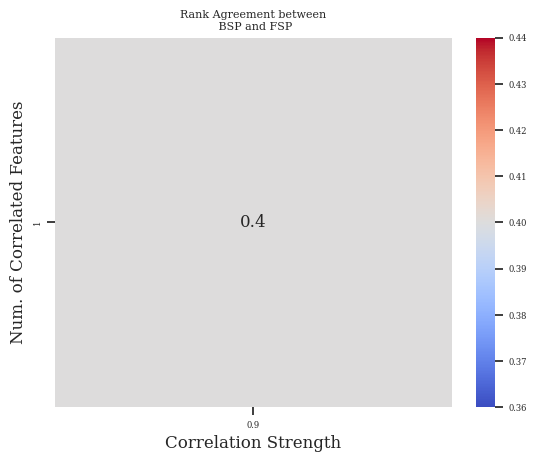

In [9]:
# Plot the heatmap with annotations
f, ax = plt.subplots(dpi=100)
sns.heatmap(sp_rank_stats, annot=True, cmap="coolwarm",ax=ax,
           yticklabels=num_correlated, xticklabels=correlation_strength)
ax.set_ylabel('Num. of Correlated Features')
ax.set_xlabel('Correlation Strength')
ax.set_title('Rank Agreement between\n BSP and FSP')
ax.invert_yaxis()

In [ ]:
# Plot the heatmap with annotations
f, ax = plt.subplots(dpi=100)
sns.heatmap(mp_rank_stats, annot=True, cmap="coolwarm",ax=ax,
           yticklabels=num_correlated, xticklabels=correlation_strength)
ax.set_ylabel('Num. of Correlated Features')
ax.set_xlabel('Correlation Strength')
ax.set_title('Rank Agreement between\n BMP and FMP')
#ax.invert_yaxis()